In [1]:
from torchvision import transforms
import torch
from torch import nn
import torch.optim as optim
import argparse
import torch.optim.lr_scheduler as lr_scheduler 
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import preprocessing
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
import warnings
from timeit import default_timer as timer
warnings.simplefilter('ignore')

In [2]:
#Test
class MyTestSet(Dataset):
    def __init__(self, img):
        self.img = np.load(img)
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :]
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        return img
    def __len__(self):
        return self.img.shape[0]

In [3]:
test = MyTestSet("./pretrained/test_pre.npy")
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

In [4]:
file = open("./pretrained/label_encoder_pre.obj",'rb')
le = pickle.load(file)
file.close()
trainy = pd.read_csv("./pretrained/trainy_pre.csv")
classes = len(np.unique(trainy['celltype_l2']))

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
mod =EfficientNet.from_pretrained('efficientnet-b3', num_classes=classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    mod = nn.DataParallel(mod)

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name()

mod.to(device)
mod = mod.to(device)
mod.load_state_dict(torch.load(("./pretrained/checkpoint_model_pre.pth")))
mod.eval()

Loaded pretrained weights for efficientnet-b3


DataParallel(
  (module): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [6]:
out = []
for i, data in enumerate(test_loader):
    query = data
    query = query.to(device)
    pred= mod(query)
    _, predicted = torch.max(pred.data, 1)
    out.append(predicted)

pred = torch.cat(out, dim=0)
pr = pred.cpu().numpy()

In [7]:
real_label = pd.read_csv("./pretrained/testy_pre.csv", index_col=0)
real_label.value_counts()

celltype_l2      
CD14 Mono            2132
CD4 Naive             874
NK                    859
CD4 TCM               745
CD8 TEM               587
CD8 Naive             539
B naive               385
CD16 Mono             315
CD4 TEM               214
gdT                   183
B memory              164
CD8 TCM               144
MAIT                  139
Treg                  125
cDC2                  123
B intermediate        121
Platelet              114
CD4 CTL                87
NK_CD56bright          47
pDC                    43
Doublet                29
NK Proliferating       27
dnT                    17
Plasmablast            16
HSPC                   16
ILC                     7
cDC1                    7
Eryth                   4
CD8 Proliferating       4
ASDC                    4
CD4 Proliferating       3
dtype: int64

In [8]:
file = open("./pretrained/label_encoder_pre.obj",'rb')
le = pickle.load(file)
file.close()
pred_label = le.inverse_transform(pr)
pred_label = pd.DataFrame(pred_label)
pred_label.value_counts()

CD14 Mono            2135
CD4 Naive             895
NK                    847
CD4 TCM               737
CD8 TEM               575
CD8 Naive             542
B naive               387
CD16 Mono             325
CD4 TEM               220
gdT                   186
B memory              162
CD8 TCM               144
MAIT                  139
cDC2                  123
B intermediate        121
Treg                  116
Platelet              109
CD4 CTL                88
NK_CD56bright          56
pDC                    43
NK Proliferating       32
dnT                    19
HSPC                   16
Plasmablast            16
Doublet                15
ILC                     7
cDC1                    7
Eryth                   4
ASDC                    4
CD8 Proliferating       2
CD4 Proliferating       2
dtype: int64

In [9]:
ls = list(set(pd.unique(pred_label[0]).tolist()) | set(pd.unique(real_label["celltype_l2"]).tolist()))
acc = accuracy_score(pred_label,real_label)

le2 = preprocessing.LabelEncoder()
le2.fit(ls)
pred_label_2 = le2.transform(pred_label[0])
real_label_2 = le2.transform(real_label["celltype_l2"])
ari = adjusted_rand_score(real_label_2, pred_label_2)

print("Accuray: %.03f, ARI = %.03f" % (acc, ari))

Accuray: 0.953, ARI = 0.945


In [10]:
import torch.nn.functional as nnf
pros = []
for i, data in enumerate(test_loader):
    query = data
    query = query.to(device)
    pred = mod(query)
    p = nnf.softmax(pred.data).cpu()
    pros.append(p)

In [11]:
prob = torch.cat(pros, dim=0)
prob

tensor([[0.0034, 0.0035, 0.0035,  ..., 0.0034, 0.0035, 0.0034],
        [0.0032, 0.0033, 0.0033,  ..., 0.0032, 0.0035, 0.0033],
        [0.0034, 0.0035, 0.0036,  ..., 0.0034, 0.0036, 0.0034],
        ...,
        [0.0026, 0.0020, 0.0023,  ..., 0.0022, 0.0021, 0.0024],
        [0.0017, 0.0017, 0.0015,  ..., 0.0018, 0.0016, 0.0018],
        [0.0023, 0.0028, 0.0019,  ..., 0.0021, 0.0020, 0.0024]])

In [12]:
max_prob, predicted_classes = torch.max(prob, axis=1)
max_prob

tensor([0.8967, 0.9005, 0.8958,  ..., 0.9311, 0.9518, 0.9383])

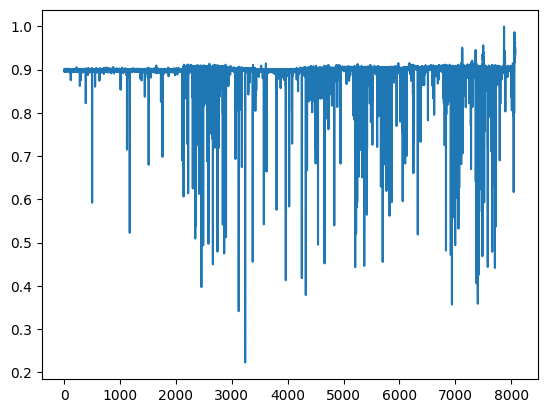

In [13]:
plt.plot(max_prob)

<AxesSubplot:ylabel='Density'>

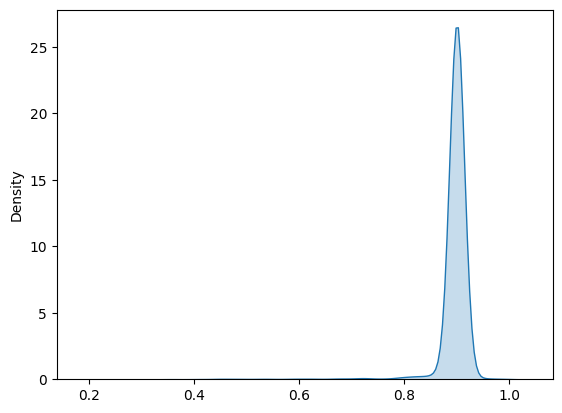

In [14]:
import seaborn as sns
sns.kdeplot(max_prob, bw_adjust=2, fill=True)

In [15]:
from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(real_label_2, prob, multi_class='ovr')
print("AUROC: %.03f" % auroc)

AUROC: 0.987


In [16]:
from torchmetrics.classification import AveragePrecision
average_precision = AveragePrecision(task="multiclass", num_classes=classes, average="weighted")
aurpc_weighted = average_precision(prob, torch.from_numpy(real_label_2))
print("AURPC (weighted): %.03f" % aurpc_weighted)

AURPC (weighted): 0.961


In [17]:
from torchmetrics.classification import AveragePrecision
average_precision = AveragePrecision(task="multiclass", num_classes=classes, average="macro")
aurpc_macro = average_precision(prob, torch.from_numpy(real_label_2))
print("AURPC (macro): %.03f" % aurpc_macro)

AURPC (macro): 0.922


In [18]:
from sklearn.metrics import f1_score
f1_score(real_label_2, pred_label_2, average=None)

array([1.        , 0.82644628, 0.93865031, 0.96632124, 0.9913288 ,
       0.96875   , 0.93714286, 0.95421142, 0.8       , 0.90283401,
       0.82488479, 0.98242368, 0.66666667, 0.88194444, 0.95180723,
       0.68181818, 0.75      , 1.        , 1.        , 0.96402878,
       0.98241501, 0.91525424, 0.89320388, 1.        , 0.96860987,
       0.78838174, 1.        , 0.97560976, 0.77777778, 0.89430894,
       1.        ])

In [19]:
f1_weighted = f1_score(real_label_2, pred_label_2, average='weighted')
print("F1-score(weighted): %.03f" % f1_weighted)

F1-score(weighted): 0.953


In [20]:
f1_macro = f1_score(real_label_2, pred_label_2, average='macro')
print("F1-score(weighted): %.03f" % f1_macro)

F1-score(weighted): 0.909
